# Flagship Cluster Posterior Analysis (Parallel SBI)

This notebook analyzes posterior distributions from the parallel SBI pipeline.

**Parameters:**
- Omega_m: matter density
- sigma8: amplitude of matter fluctuations  
- alpha_lambda: mass-richness relation normalization
- beta_lambda: mass-richness relation slope

**Data:** Euclid Flagship cluster catalogue

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import pickle
import torch

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

print(f"Project root: {project_root}")

Project root: /pbs/home/c/cmurray/cluster_likelihood


## Configuration

Set the job ID to load results from a specific parallel SBI run.

In [2]:
# Set job ID (or use checkpoint/final output)
JOB_ID = "14183725"  # Update this to your job ID

# Paths
scripts_dir = Path.cwd() / 'scripts'
checkpoint_path = scripts_dir / 'checkpoints' / f'flagship_posterior_{JOB_ID}_checkpoint.pkl'
outputs_dir = scripts_dir / 'outputs'
posterior_path = outputs_dir / f'flagship_posterior_{JOB_ID}.pkl'
simulations_path = outputs_dir / f'flagship_posterior_{JOB_ID}_simulations.pkl'

# Try trained posterior first, then checkpoint
if posterior_path.exists() and simulations_path.exists():
    results_path = simulations_path
    print(f"Loading TRAINED POSTERIOR from: {posterior_path}")
    print(f"Loading simulations from: {simulations_path}")
    use_trained_posterior = True
elif checkpoint_path.exists():
    results_path = checkpoint_path
    print(f"Loading CHECKPOINT from: {results_path}")
    use_trained_posterior = False
else:
    raise FileNotFoundError(f"No results found for job {JOB_ID}")

print(f"\nFile size: {results_path.stat().st_size / 1024:.1f} KB")

Loading TRAINED POSTERIOR from: /pbs/home/c/cmurray/cluster_likelihood/notebooks/calum/scripts/outputs/flagship_posterior_14183725.pkl
Loading simulations from: /pbs/home/c/cmurray/cluster_likelihood/notebooks/calum/scripts/outputs/flagship_posterior_14183725_simulations.pkl

File size: 3281.7 KB


## 1. Load Parallel SBI Results

In [3]:
# Load results
with open(results_path, 'rb') as f:
    results = pickle.load(f)

# Load trained posterior if available
if use_trained_posterior:
    with open(posterior_path, 'rb') as f:
        posterior = pickle.load(f)
    print(f"Loaded trained posterior: {type(posterior).__name__}")
else:
    posterior = None

# Extract simulation data
if 'results' in results:
    # Checkpoint format: has 'results' wrapper
    res_data = results['results']
    
    theta_valid_list = res_data['theta']
    x_valid_list = res_data['x']
    failed_theta_list = res_data['failed_theta']
    
    theta_valid = np.array(theta_valid_list)
    failed_theta = np.array(failed_theta_list)
    
    # Convert x (handle tuple format)
    if len(x_valid_list) > 0 and isinstance(x_valid_list[0], tuple):
        x_valid = []
        for x_sample in x_valid_list:
            counts, masses = x_sample
            flat_sample = np.concatenate([counts.flatten(), masses.flatten()])
            x_valid.append(flat_sample)
        x_valid = np.array(x_valid)
    else:
        x_valid = np.array(x_valid_list)
    
    n_valid = len(theta_valid)
    n_failed = len(failed_theta)
    theta_samples = np.vstack([theta_valid, failed_theta]) if n_failed > 0 else theta_valid
    valid_mask = np.array([True]*n_valid + [False]*n_failed)
    
else:
    # Final output format from run_sbi_parallel.py
    theta_valid = results['theta']
    failed_theta = results['failed_theta']
    
    # Handle x (already processed or tuple format)
    if isinstance(results['x'], tuple):
        # Tuple of arrays (counts, masses)
        counts_array, masses_array = results['x']
        x_valid = np.concatenate([counts_array.reshape(len(counts_array), -1),
                                  masses_array.reshape(len(masses_array), -1)], axis=1)
    else:
        x_valid = results['x']
    
    n_valid = results['n_success']
    n_failed = results['n_failed']
    theta_samples = np.vstack([theta_valid, failed_theta]) if n_failed > 0 else theta_valid
    valid_mask = np.array([True]*n_valid + [False]*n_failed)

print("="*70)
print("PARALLEL SBI RESULTS")
print("="*70)
print(f"Total simulations attempted: {len(theta_samples)}")
print(f"Valid simulations: {np.sum(valid_mask)} ({100*np.mean(valid_mask):.1f}%)")
print(f"Failed simulations: {np.sum(~valid_mask)} ({100*np.mean(~valid_mask):.1f}%)")
print(f"\nParameter samples shape: {theta_valid.shape}")
print(f"Summary statistics shape: {x_valid.shape}")
print(f"\nPosterior trained: {posterior is not None}")
print("="*70)

/sps/euclid/Users/cmurray/miniconda3/envs/capish/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded trained posterior: DirectPosterior
PARALLEL SBI RESULTS
Total simulations attempted: 10000
Valid simulations: 10000 (100.0%)
Failed simulations: 0 (0.0%)

Parameter samples shape: (10000, 4)
Summary statistics shape: (10000, 40)

Posterior trained: True


## 2. Train Posterior (if not already trained)

If loading from checkpoint, we need to train the posterior.

In [4]:
from sbi.utils import BoxUniform
from sbi.inference import SNPE

if posterior is None:
    print("Posterior not found - training from scratch...\n")
    
    # Define prior (must match run_sbi_parallel.py)
    prior_min = torch.tensor([0.15, 0.65, -10.5, 0.5])
    prior_max = torch.tensor([0.45, 0.95, -8.0, 1.0])
    prior = BoxUniform(low=prior_min, high=prior_max)
    
    # Convert to torch tensors
    theta_torch = torch.tensor(theta_valid, dtype=torch.float32)
    x_torch = torch.tensor(x_valid, dtype=torch.float32)
    
    # Train
    inference = SNPE(prior=prior)
    training_batch_size = min(50, max(10, len(theta_valid) // 10))
    
    print(f"Training with {len(theta_valid)} samples...")
    print(f"Batch size: {training_batch_size}")
    
    density_estimator = inference.append_simulations(theta_torch, x_torch).train(
        training_batch_size=training_batch_size
    )
    posterior = inference.build_posterior(density_estimator)
    
    print("\nPosterior training complete!")
else:
    print("Using pre-trained posterior loaded from file.")
    print(f"Trained on {len(theta_valid)} simulations with {len(failed_theta)} failures.")

Using pre-trained posterior loaded from file.
Trained on 10000 simulations with 0 failures.


## 3. Load Flagship Observed Data

In [5]:
# Load Flagship summary statistics
flagship_path = project_root / 'euclid_flagship_simulations' / 'flagship_cluster_catalogue_summary_statstics_DES_MoR_Mwl_scatter_Gamma0.7.npy'
flagship_data = np.load(flagship_path, allow_pickle=True).item()

# Use M200b definition
flagship_counts = flagship_data['count_with_m200b_def']
flagship_mean_masses = flagship_data['mean_log10m200b']

# Create observed data vector (matching simulation pipeline)
observed_counts = flagship_counts.flatten()
observed_masses = flagship_mean_masses.flatten()
observed_data = np.concatenate([observed_counts, observed_masses])
observed_data_tensor = torch.tensor(observed_data, dtype=torch.float32)

print(f"Observed data vector shape: {observed_data.shape}")
print(f"  - Count bins: {len(observed_counts)}")
print(f"  - Mass bins: {len(observed_masses)}")
print(f"\nData vector summary:")
print(f"  - Min: {observed_data.min():.2f}")
print(f"  - Max: {observed_data.max():.2f}")
print(f"  - Mean: {observed_data.mean():.2f}")

Observed data vector shape: (40,)
  - Count bins: 20
  - Mass bins: 20

Data vector summary:
  - Min: 1.00
  - Max: 31809.00
  - Mean: 2037.77


## 4. Sample Posterior

In [6]:
# Number of posterior samples to draw
num_samples = 500000

print(f"Drawing {num_samples} samples from the posterior...")
posterior_samples = posterior.sample((num_samples,), x=observed_data_tensor)
posterior_samples_np = posterior_samples.cpu().numpy()

print(f"\nPosterior samples shape: {posterior_samples_np.shape}")
print("Done!")

Drawing 500000 samples from the posterior...


502018it [00:03, 149691.22it/s]                            


Posterior samples shape: (500000, 4)
Done!


## 5. Posterior Statistics

In [7]:
# Parameter names
param_names = ['Omega_m', 'sigma8', 'alpha_lambda', 'beta_lambda']
param_labels = [r'$\Omega_m$', r'$\sigma_8$', r'$\alpha_\lambda$', r'$\beta_\lambda$']

# Fiducial values (Euclid Flagship cosmology)
fiducial_values = [0.319, 0.813, -9.348, 0.75]

# Calculate percentiles
percentiles = np.percentile(posterior_samples_np, [16, 50, 84], axis=0)

print("\n" + "="*80)
print("POSTERIOR CREDIBLE INTERVALS (68% confidence)")
print("="*80)
print(f"{'Parameter':<20} {'Median':<15} {'68% CI':<30} {'Fiducial':<15}")
print("-"*80)

for i, (name, fid) in enumerate(zip(param_names, fiducial_values)):
    p16, p50, p84 = percentiles[:, i]
    err_low = p50 - p16
    err_high = p84 - p50
    
    # Calculate sigma offset from fiducial
    avg_err = (err_low + err_high) / 2
    n_sigma = abs(p50 - fid) / avg_err if avg_err > 0 else 0
    
    print(f"{name:<20} {p50:>7.4f}        +{err_high:<7.4f} -{err_low:<7.4f}     {fid:>7.4f} ({n_sigma:.1f}σ)")

print("="*80)


POSTERIOR CREDIBLE INTERVALS (68% confidence)
Parameter            Median          68% CI                         Fiducial       
--------------------------------------------------------------------------------
Omega_m               0.3177        +0.0608  -0.0598       0.3190 (0.0σ)
sigma8                0.7924        +0.0419  -0.0431       0.8130 (0.5σ)
alpha_lambda         -9.8087        +0.7269  -0.4399      -9.3480 (0.8σ)
beta_lambda           0.7818        +0.0330  -0.0525       0.7500 (0.7σ)


## 6. Corner Plot

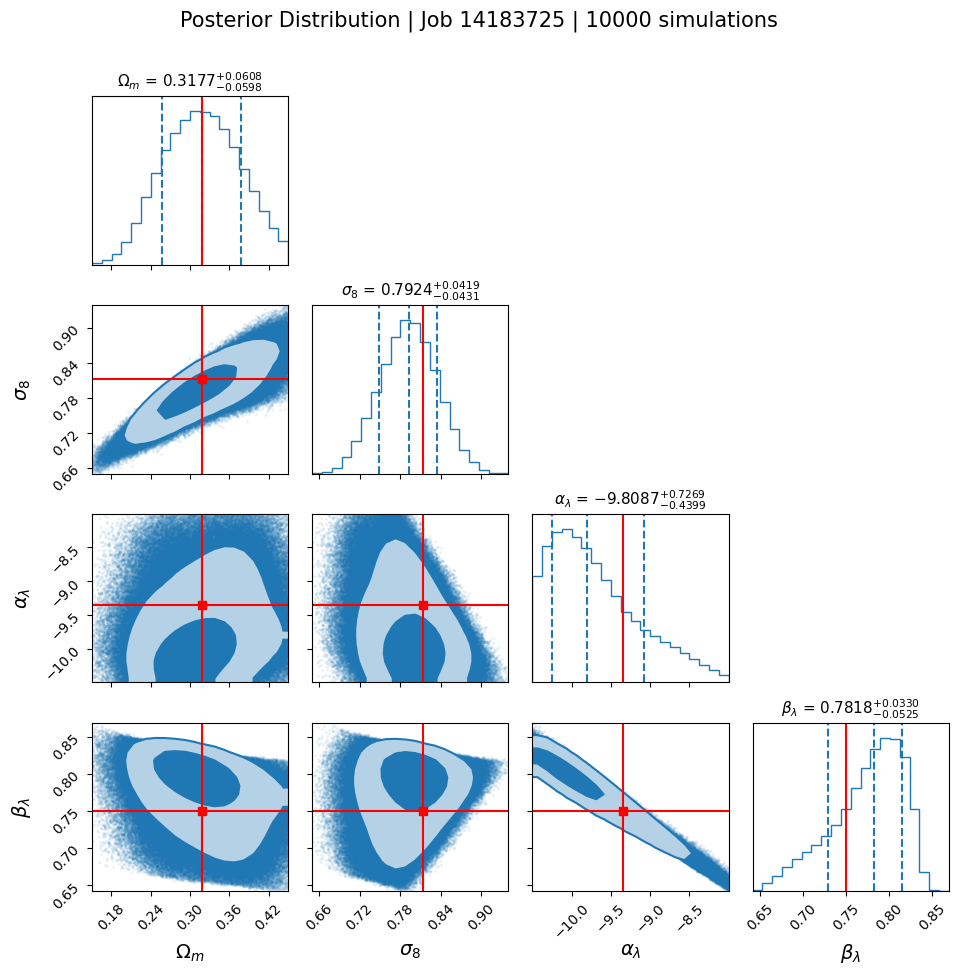


Saved: /pbs/home/c/cmurray/cluster_likelihood/notebooks/calum/flagship_posterior_corner_14183725.png


In [8]:
try:
    import corner
except ImportError:
    print("Installing corner package...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "corner"])
    import corner

# Create corner plot with 1σ and 2σ contours
fig = corner.corner(
    posterior_samples_np,
    labels=param_labels,
    truths=fiducial_values,
    quantiles=[0.16, 0.5, 0.84],
    levels=[1 - np.exp(-0.5), 1 - np.exp(-2.0)],  # 1σ (68.3%) and 2σ (95.4%) contours
    show_titles=True,
    title_fmt='.4f',
    color='#1f77b4',
    truth_color='red',
    label_kwargs={'fontsize': 14},
    title_kwargs={'fontsize': 11},
    fill_contours=True,
    smooth=1.0
)

fig.suptitle(f'Posterior Distribution | Job {JOB_ID} | {np.sum(valid_mask)} simulations', 
             fontsize=15, y=1.01)
plt.tight_layout()
plt.show()

# Save
output_path = Path.cwd() / f'flagship_posterior_corner_{JOB_ID}.png'
fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {output_path}")

## 7. Individual Parameter Distributions

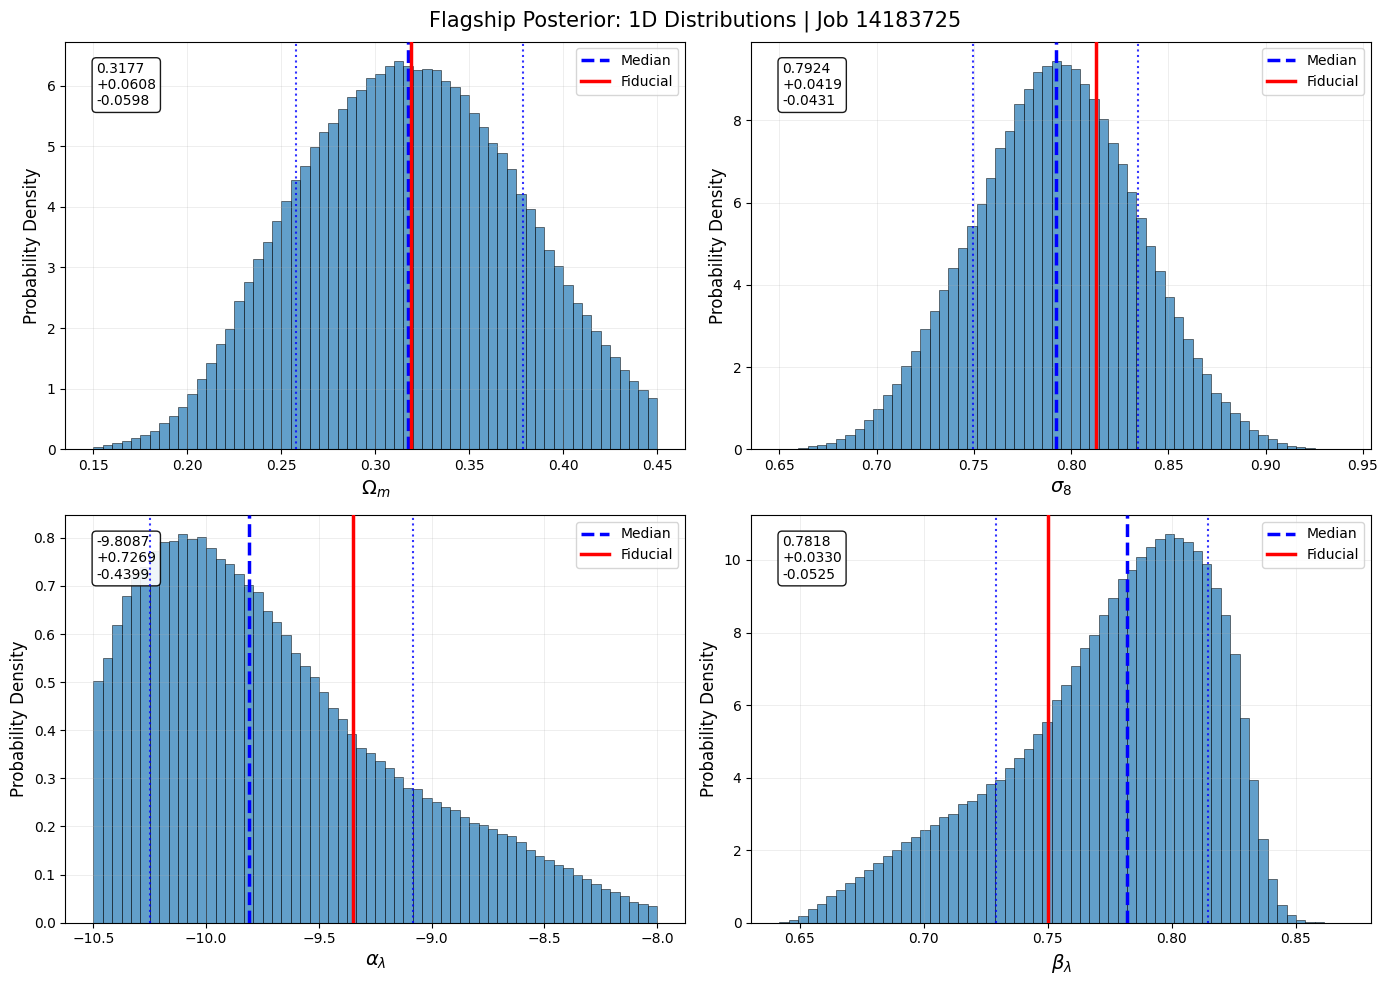


Saved: /pbs/home/c/cmurray/cluster_likelihood/notebooks/calum/flagship_posterior_1d_14183725.png


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, (name, label, fid, ax) in enumerate(zip(param_names, param_labels, fiducial_values, axes)):
    # Histogram
    ax.hist(posterior_samples_np[:, i], bins=60, alpha=0.7, color='#1f77b4', 
            edgecolor='black', linewidth=0.5, density=True)
    
    # Percentiles
    p16, p50, p84 = percentiles[:, i]
    ax.axvline(p50, color='blue', linewidth=2.5, linestyle='--', label='Median', zorder=10)
    ax.axvline(p16, color='blue', linewidth=1.5, linestyle=':', alpha=0.8, zorder=10)
    ax.axvline(p84, color='blue', linewidth=1.5, linestyle=':', alpha=0.8, zorder=10)
    
    # Fiducial
    ax.axvline(fid, color='red', linewidth=2.5, label='Fiducial', zorder=10)
    
    # Labels
    ax.set_xlabel(label, fontsize=14)
    ax.set_ylabel('Probability Density', fontsize=12)
    ax.legend(fontsize=10, loc='upper right')
    ax.grid(True, alpha=0.3, linewidth=0.5)
    
    # Credible interval text
    err_low = p50 - p16
    err_high = p84 - p50
    text = f"{p50:.4f}\n+{err_high:.4f}\n-{err_low:.4f}"
    ax.text(0.05, 0.95, text, transform=ax.transAxes, 
            verticalalignment='top', fontsize=10,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='black'))

plt.suptitle(f'Flagship Posterior: 1D Distributions | Job {JOB_ID}', fontsize=15)
plt.tight_layout()
plt.show()

# Save
output_path = Path.cwd() / f'flagship_posterior_1d_{JOB_ID}.png'
fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {output_path}")

## 8. Correlation Matrix

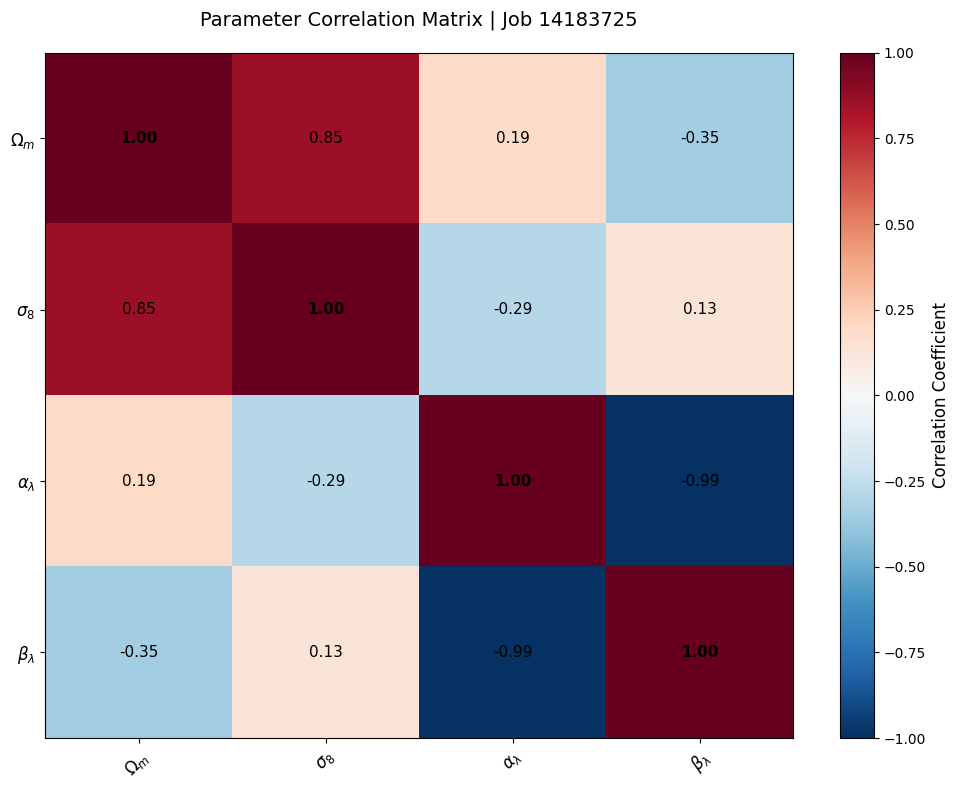


CORRELATION MATRIX
                       Omega_m         sigma8   alpha_lambda    beta_lambda
----------------------------------------------------------------------
        Omega_m          1.000          0.855          0.191         -0.345
         sigma8          0.855          1.000         -0.286          0.129
   alpha_lambda          0.191         -0.286          1.000         -0.986
    beta_lambda         -0.345          0.129         -0.986          1.000


In [10]:
# Calculate correlation matrix
corr_matrix = np.corrcoef(posterior_samples_np.T)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', fontsize=12)

# Ticks
ax.set_xticks(range(len(param_names)))
ax.set_yticks(range(len(param_names)))
ax.set_xticklabels(param_labels, fontsize=12)
ax.set_yticklabels(param_labels, fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# Add values
for i in range(len(param_names)):
    for j in range(len(param_names)):
        text = ax.text(j, i, f"{corr_matrix[i, j]:.2f}",
                      ha="center", va="center", color="black", fontsize=11,
                      weight='bold' if i == j else 'normal')

ax.set_title(f'Parameter Correlation Matrix | Job {JOB_ID}', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Print
print("\n" + "="*70)
print("CORRELATION MATRIX")
print("="*70)
print(f"{'':>15}", end="")
for name in param_names:
    print(f"{name:>15}", end="")
print()
print("-"*70)

for i, name in enumerate(param_names):
    print(f"{name:>15}", end="")
    for j in range(len(param_names)):
        print(f"{corr_matrix[i, j]:>15.3f}", end="")
    print()
print("="*70)

## 9. Training Data Visualization

Visualize the parameter space coverage from the parallel simulations.

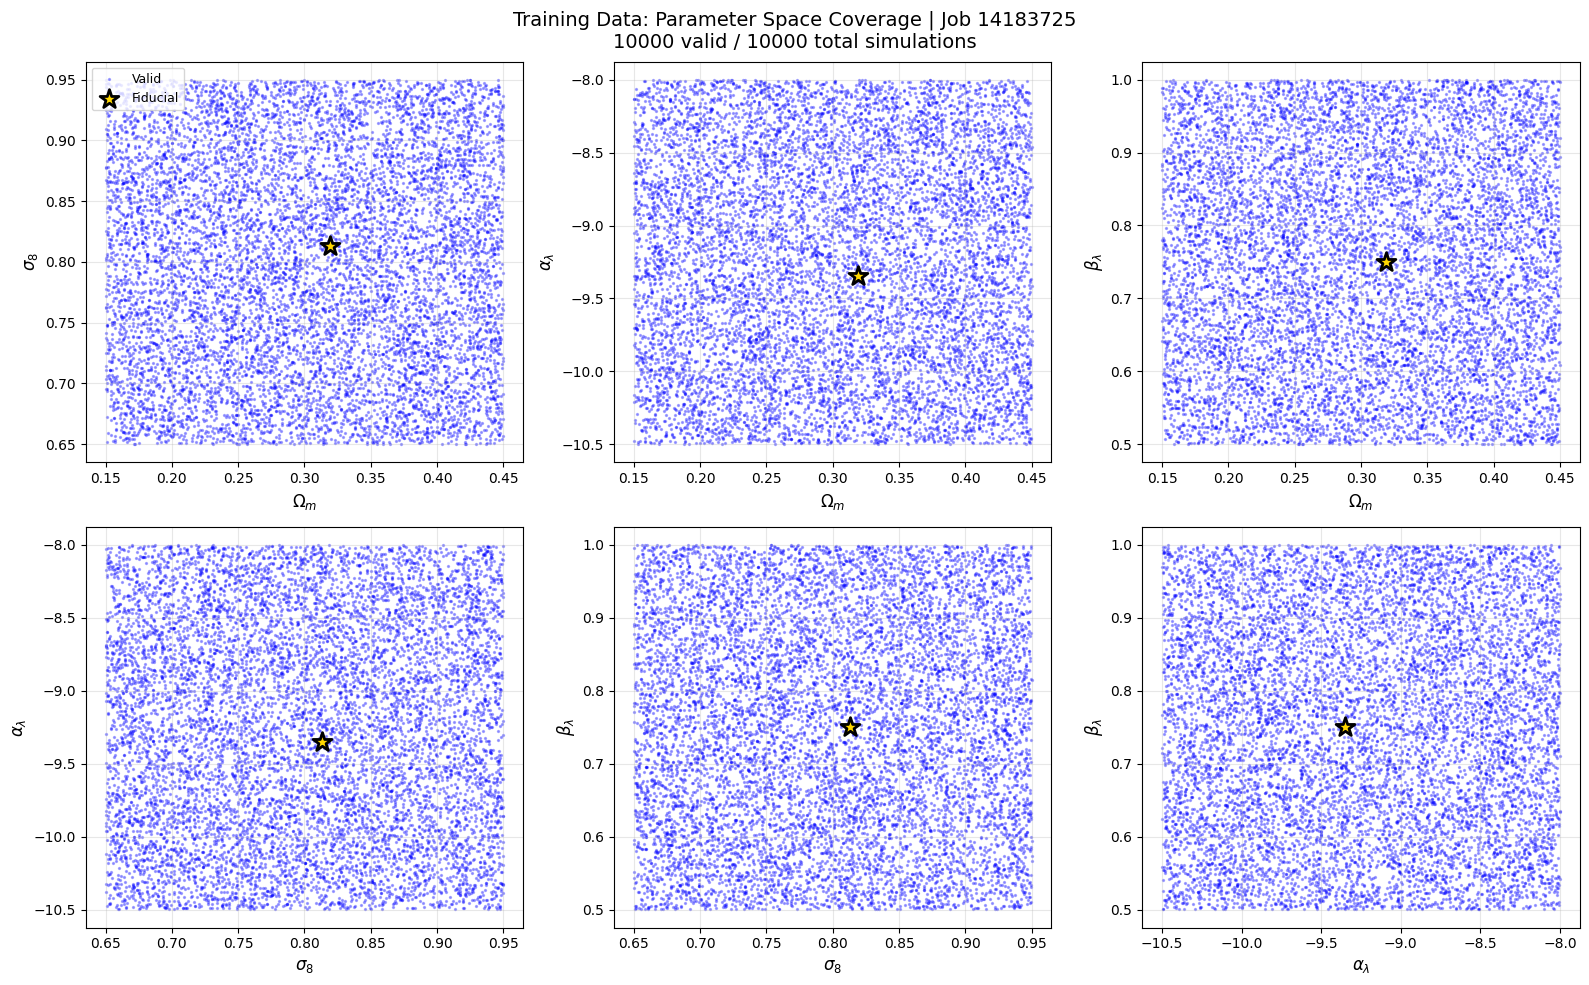


Saved: /pbs/home/c/cmurray/cluster_likelihood/notebooks/calum/flagship_training_coverage_14183725.png


In [11]:
# Plot training samples in parameter space
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

# Parameter pairs to plot
pairs = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
pair_labels = [
    (param_labels[i], param_labels[j]) for i, j in pairs
]

for ax, (i, j), (xlabel, ylabel) in zip(axes, pairs, pair_labels):
    # Plot valid samples
    ax.scatter(theta_valid[:, i], theta_valid[:, j], 
               s=2, alpha=0.3, c='blue', label='Valid')
    
    # Plot failed samples if any
    theta_failed = theta_samples[~valid_mask]
    if len(theta_failed) > 0:
        ax.scatter(theta_failed[:, i], theta_failed[:, j],
                   s=2, alpha=0.3, c='red', label='Failed', marker='x')
    
    # Fiducial
    ax.scatter(fiducial_values[i], fiducial_values[j],
               s=200, marker='*', c='gold', edgecolors='black', 
               linewidths=2, label='Fiducial', zorder=10)
    
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, alpha=0.3)
    if ax == axes[0]:
        ax.legend(fontsize=9)

plt.suptitle(f'Training Data: Parameter Space Coverage | Job {JOB_ID}\n'
             f'{np.sum(valid_mask)} valid / {len(theta_samples)} total simulations',
             fontsize=14)
plt.tight_layout()
plt.show()

# Save
output_path = Path.cwd() / f'flagship_training_coverage_{JOB_ID}.png'
fig.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"\nSaved: {output_path}")

## Summary

This notebook:
1. Loads results from parallel SBI training (checkpoint or final output)
2. Trains the posterior if needed (from checkpoint)
3. Samples the posterior conditioned on Flagship observations
4. Analyzes and visualizes parameter constraints
5. Shows training data coverage in parameter space

The parallel pipeline enables fast inference on cosmological parameters and mass-observable relations using the Euclid Flagship cluster catalogue.